https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb

## Imports

In [9]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import gc
import timm
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Utility functions

In [10]:
def imshow(img, text = None,should_save = False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, fontweight = 'bold',
            bbox = {'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_save_plot(iteration, loss, save = False):
    plt.plot(iteration, loss)
    plt.show()
    if save == True:
        save_path = Config.SAVE_DIR + 'loss_plot_' + str(Config.EPOCHS) + '_' + str(Config.IMG_MODE) + '.png'
        plt.savefig(save_path)

## Configuration

In [11]:
class Config():
    TRAIN_DIR = "data/train/"
    TEST_DIR = "data/test/"
    SAVE_DIR = "trained_models/"
    
    IMG_MODE = "RGB"
    RES_H = 224
    RES_V = 224
    
    BATCH = 80
    EPOCHS = 600
    LEARNING_RATE = 0.0005
    INF_ITER = 140
    SILENT_INF = True

    transform = {
            'train': transforms.Compose([transforms.Resize((RES_H, RES_V)),
                                        transforms.ToTensor(),
                                        transforms.RandomHorizontalFlip()                                                                  
            ]),
            'test': transforms.Compose([transforms.Resize((RES_H, RES_V)),
                                        transforms.ToTensor(),
                                        transforms.RandomHorizontalFlip()    
            ])
        }

## Dataset definition

In [12]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        image0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                image1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if image0_tuple[1]==image1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found             
                image1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if image0_tuple[1] !=image1_tuple[1]:
                    break

        image0 = Image.open(image0_tuple[0])
        image0 = image0.convert(Config.IMG_MODE)
        
        image1 = Image.open(image1_tuple[0])
        image1 = image1.convert(Config.IMG_MODE)
        
        
        if self.should_invert:
            image0 = PIL.ImageOps.invert(image0)
            image1 = PIL.ImageOps.invert(image1)

        if self.transform is not None:
            image0 = self.transform(image0)
            image1 = self.transform(image1)
        
        return image0, image1, torch.from_numpy(np.array([int(image1_tuple[1]!=image0_tuple[1])],dtype=np.float32)), image0_tuple, image1_tuple
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Loading data

In [13]:
folder_dataset = dset.ImageFolder(root=Config.TRAIN_DIR)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=Config.transform['train']
                                       ,should_invert=False)

## Example snippet from the dataset

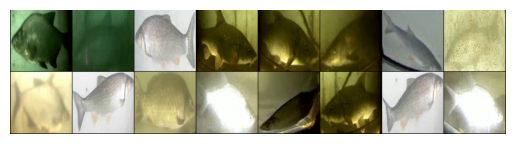

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [6]:
example_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(example_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Network and loss function definitions

In [14]:
## Implementation of resnet50
## timm dock:
## https://timm.fast.ai/models
## https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-nn-module
class SiameseNetwork(nn.Module):
    def __init__(self, emb_size = 256):
        super(SiameseNetwork, self).__init__()
        
        #Grayscale
        if Config.IMG_MODE == "L":
            self.resnet = timm.create_model('resnet50', pretrained = False, in_chans=1)
        
        #RGB
        elif Config.IMG_MODE == "RGB":
            self.resnet = timm.create_model('resnet50', pretrained = False)
        modules = list(self.resnet.children())
        self.resnet = nn.Sequential(*modules)


    def forward(self, input1, input2):
        output1 = self.resnet(input1)
        output2 = self.resnet(input2)
        return output1, output2

In [15]:
## Contrastive loss:
## https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec
##
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


## Model training

### Configuration

In [16]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.BATCH)

network = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(network.parameters(),lr = Config.LEARNING_RATE)

counter = []
loss_history = [] 
iteration_number= 0

best_loss_contrastive = np.Inf

### Training loop

Epoch number 0
 Current loss 11.654324531555176

SAVED MODEL: 
 Epoch number 0
 Loss 11.654324531555176

SAVED MODEL: 
 Epoch number 0
 Loss 3.0135598182678223

SAVED MODEL: 
 Epoch number 0
 Loss 2.5100135803222656

SAVED MODEL: 
 Epoch number 0
 Loss 1.3259387016296387

SAVED MODEL: 
 Epoch number 0
 Loss 0.9240663647651672

SAVED MODEL: 
 Epoch number 0
 Loss 0.7284942865371704

Epoch number 1
 Current loss 0.8896522521972656

SAVED MODEL: 
 Epoch number 1
 Loss 0.6836416125297546

SAVED MODEL: 
 Epoch number 1
 Loss 0.6348856091499329

Epoch number 2
 Current loss 0.758520781993866

SAVED MODEL: 
 Epoch number 2
 Loss 0.5869506001472473

SAVED MODEL: 
 Epoch number 2
 Loss 0.1877642422914505

Epoch number 3
 Current loss 0.6859316825866699

Epoch number 4
 Current loss 0.767708957195282

Epoch number 5
 Current loss 0.6288949847221375

Epoch number 6
 Current loss 0.7248277068138123

Epoch number 7
 Current loss 0.7763304114341736

Epoch number 8
 Current loss 0.5894980430603027

E

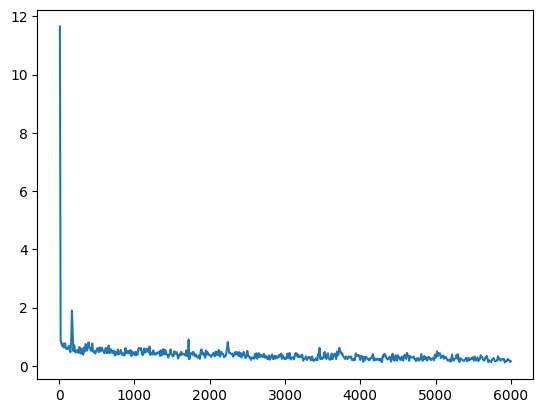

<Figure size 640x480 with 0 Axes>

In [9]:
for epoch in range(0, Config.EPOCHS):
    
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label,_,_ = data
        img0, img1, label= img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        output1,output2 = network(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        if i % 20 == 0 :
            print(f'Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n')
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
        if loss_contrastive == 0:
            break
        
        if loss_contrastive < best_loss_contrastive:            
            save_path = Config.SAVE_DIR + 'best_model_' + str(Config.EPOCHS) + '_' + str(Config.IMG_MODE) + '.pt'
            torch.save(network.state_dict(), save_path)
            best_loss_contrastive = loss_contrastive
            print(f'SAVED MODEL: \n Epoch number {epoch}\n Loss {loss_contrastive.item()}\n' )
            
show_save_plot(counter, loss_history, save = True)

## Inference

In [18]:
folder_dataset_test = dset.ImageFolder(root=Config.TEST_DIR)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=Config.transform['test']
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

image0,_,_,name_class0,_ = next(dataiter)

load_path = str(Config.SAVE_DIR) + 'best_model_' + str(Config.EPOCHS) + '_' + str(Config.IMG_MODE) + '.pt'
network.load_state_dict(torch.load(load_path))

print(f'Using model: {load_path}\n')
print(f'Fish: {str(name_class0[0]).split("/")[2]}\
\nClass number: {name_class0[1].item()}')
      
barbel = [0, 0, 'barbel']
bleak = [0, 0, 'bleak']
bream = [0, 0, 'bream']
carp = [0, 0, 'carp']
catfish = [0, 0, 'catfish']
chub = [0, 0, 'chub']
eel = [0, 0, 'eel']
nase = [0, 0, 'nase']
perch = [0, 0, 'perch']
roach = [0, 0, 'roach']

fish_tuple = (barbel, bleak, bream, carp, catfish, chub, eel, nase, perch, roach)

for i in range(Config.INF_ITER):
    _,image1,_,_,name_class1 = next(dataiter)

    concatenated = torch.cat((image0,image1),0)
    
    output1,output2 = network(Variable(image0).cuda(),Variable(image1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    for index,_ in enumerate(fish_tuple):
        if name_class1[1].item() != index:
            continue
        else:
            fish_tuple[index][0] += euclidean_distance.item()
            fish_tuple[index][1] += 1 

    if Config.SILENT_INF == False:
        class_dissimilarity = f'Class0: {name_class0[1].item()}\
        Class1: {name_class1[1].item()} \nDistance: {euclidean_distance.item():.2f}'
        
        for fish in fish_tuple:
            print(fish)

        imshow(torchvision.utils.make_grid(concatenated), class_dissimilarity)

Using model: trained_models/best_model_600_RGB.pt

Fish: catfish
Class number: 4


In [19]:
class_id = 0
best_mean_euclidean_distance = [np.inf, 0]

for index, fish in enumerate(fish_tuple):
    mean_euclidean_distance = fish[0] / fish[1]

    if mean_euclidean_distance < best_mean_euclidean_distance[0]:
        best_mean_euclidean_distance[0] = mean_euclidean_distance
        best_mean_euclidean_distance[1] = index
        class_id = index
    
distance_class_fish = f'Best mean distance: {best_mean_euclidean_distance[0]:.3f}\
\nClass: {best_mean_euclidean_distance[1]}\
\nFish: {fish_tuple[class_id][2]}'

print(distance_class_fish)

euc_distance_list = list(best_mean_euclidean_distance)
euc_distance_list.append(fish_tuple[class_id][2])
print(euc_distance_list)

Best mean distance: 0.188
Class: 5
Fish: chub
[0.1875737143250612, 5, 'chub']


## Command for creating testing dataset

In [41]:
!for folder in bboxes_cleaned/*; do echo "${folder}"; ls "${folder}" | shuf -n 10 | xargs -i cp --parents -r "$folder/"{} data/test/; done

bboxes_cleaned/barbel
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_138_bbox_62_284_607_565.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_96_bbox_180_293_624_539.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_4_bbox_487_370_639_506.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_87_bbox_217_296_636_527.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_45_bbox_369_393_638_564.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_171_bbox_142_359_581_576.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20170507_132901872_frame_84_bbox_225_301_638_531.png': No such file or directory
cp: cannot stat 'bboxes_cleaned/barbel/*20190930_155816446_frame_17_bbox_117_482_333_561.png': No such file or directory
cp: cannot

In [ ]:
!for folder in data/test/*; do ls "$folder" | xargs -i echo "${folder}/"{} | sed -e 's/test/train/g' | xargs -i rm {} ; done

## Clean up

In [19]:
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

0